In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os 
import matplotlib.pyplot as plt
import argparse
import pandas as pd
import os 
from functools import partial
# compressors  Gzip, Snappy, Brotli, LZ4, Zstandard, BZ2, and LZMA
import gzip
import snappy
import brotli
import lz4
import zstandard as zstd
import bz2
import lzma
import time
from pathos.multiprocessing import ProcessingPool as Pool
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix


%matplotlib inline

In [20]:
# Necessary function definitions
def zstd_compress(data):
    cctx = zstd.ZstdCompressor()
    return cctx.compress(data)

def zstd_decompress(data):
    dctx = zstd.ZstdDecompressor()
    return dctx.decompress(data)

def create_data_sets(df, train_percent=0.8):
    # shuffle the data
    df = df.sample(frac=1).reset_index(drop=True)
    # split the data
    train_size = int(len(df) * train_percent)
    train_df = df[:train_size]
    test_df = df[train_size:]
    return train_df, test_df

# function to calculate distance between two entries in train and test
# returns the distance between the two entries
def distance_calc(compression, test, train, i, j):
    test_string = test.iloc[i]['sequence']
    train_string = train.iloc[j]['sequence']

    encoding = 'utf-8'
    # set the compression algorithm    
    if compression in ['gzip', 'snappy', 'brotli', 'bz2']:
        compressor = globals().get(compression)
        Cx1 = len(compressor.compress(test_string.encode(encoding)))
        Cx2 = len(compressor.compress(train_string.encode(encoding)))
        Cx1x2 = len(compressor.compress((" ".join([test_string, train_string])).encode(encoding)))
    elif compression == 'lz4':
        Cx1 = len(lz4.frame.compress(test_string.encode(encoding)))
        Cx2 = len(lz4.frame.compress(train_string.encode(encoding)))
        Cx1x2 = len(lz4.frame.compress((" ".join([test_string, train_string])).encode(encoding)))
    elif compression == 'zstandard':
        Cx1 = len(zstd_compress(test_string.encode(encoding)))
        Cx2 = len(zstd_compress(train_string.encode(encoding)))
        Cx1x2 = len(zstd_compress((" ".join([test_string, train_string])).encode(encoding)))
    elif compression == 'lzma':
        Cx1 = len(lzma.compress(test_string.encode(encoding)))
        Cx2 = len(lzma.compress(train_string.encode(encoding)))
        Cx1x2 = len(lzma.compress((" ".join([test_string, train_string])).encode(encoding))) 

    distance = (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)
    return [i, j, distance]

# create distance matrix
# returns a distance matrix
def create_distance_matrix(train, test, pool, compression='gzip'):
    # create an empty matrix of size len(test) x len(train)
    # iterate over each row in train and test and calculate distance using pool
    # return the distance matrix
    distance_matrix = np.zeros((len(test), len(train)))
    # pool calculation with two ranges
    
    for i in range(len(test)):
        result = pool.map(partial(distance_calc, compression, test, train, i), range(len(train)))
        for j in result:
            distance_matrix[j[0]][j[1]] = j[2]
        print('Progress: {:.2f}%'.format((i) / (len(test)) * 100), end='\r')    
    return distance_matrix

# create confusion matrix
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

def save_results(distance_matrix, folder):
    # create a folder with the name of the compression algorithm if it doesn't exist
    if not os.path.exists(folder):
        os.makedirs(folder)
    # save the distance matrix
    np.save(folder + '/distance_matrix.npy', distance_matrix)
    return None

def load_results(folder):
    # load the distance matrix
    distance_matrix = np.load(folder + '/distance_matrix.npy')
    return distance_matrix

def save_dataset(train_df, test_df, folder='dataset'):
    # create a folder with the name of the compression algorithm if it doesn't exist
    if not os.path.exists(folder):
        os.makedirs(folder)
    # save the train and test dataframes
    train_df.to_csv(folder + '/train.csv', index=False)
    test_df.to_csv(folder + '/test.csv', index=False)
    return None

def load_dataset(folder='dataset'):
    # load the train and test dataframes
    train_df = pd.read_csv(folder + '/train.csv')
    test_df = pd.read_csv(folder + '/test.csv')
    return train_df, test_df

def create_confusion_matrix(predictions, labels):
    # Calculate the confusion matrix using sklearn
    cm = confusion_matrix(labels, predictions)
    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    return cm_normalized

def plot_confusion_matrix(folder, species, labels, predictions,fsize=14):
    # plot the confusion matrix
    plt.figure(figsize=(10, 10))
    # add title with larger font
    plt.title('Confusion matrix for the DNA Classification of the species: "{}"'.format(species), fontsize=fsize)
    # add x-axis label with larger font
    plt.xlabel('Actual Class Label', fontsize=fsize)
    # add y-axis label with larger font
    plt.ylabel('Predicted Class Label', fontsize=fsize)
    plt.xticks(fontsize=fsize)
    plt.yticks(fontsize=fsize)
    plt.imshow(create_confusion_matrix(predictions, labels), cmap=plt.cm.Blues, interpolation='None')
    # save the plot
    plt.savefig('{}/confusion_matrix_{}.png'.format(folder, species))


def plot_confusion_matrix(folder, species, labels, predictions, fsize=14):
    cm = create_confusion_matrix(predictions, labels)
    plt.figure(figsize=(10, 10))
    plt.title('Confusion matrix for the DNA Classification of "{}" species'.format(species), fontsize=fsize)
    plt.xlabel('Actual Class Label', fontsize=fsize)
    plt.ylabel('Predicted Class Label', fontsize=fsize)
    plt.xticks(fontsize=fsize)
    plt.yticks(fontsize=fsize)

    # Use a heatmap to show the values
    cax = plt.imshow(cm, cmap=plt.cm.Reds, interpolation='nearest')
    plt.colorbar(cax)

    # Add annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], '.2f'),
                     ha="center", va="center",
                     color="black", fontsize=fsize)

    plt.savefig('{}/confusion_matrix_{}.png'.format(folder, species))

In [4]:
# Read the data files
chimp_dna = pd.read_table('chimpanzee.txt') # read the chimpanzee data
human_dna = pd.read_table('human.txt') # read the human data
dog_dna = pd.read_table('dog.txt') # read the dog data

In [111]:
# Create individual data sets for each species
train_df_chimp, test_df_chimp = create_data_sets(chimp_dna, train_percent=0.8)
train_df_human, test_df_human = create_data_sets(human_dna, train_percent=0.8)
train_df_dog, test_df_dog = create_data_sets(dog_dna, train_percent=0.8)

# create a dataframe with all the training data but add a column called species
train_df_chimp['species'] = 'chimp'
train_df_human['species'] = 'human'
train_df_dog['species'] = 'dog'
# concatenate all the training dataframes into one
train_df = pd.concat([train_df_chimp, train_df_human, train_df_dog])

# create a dataframe with all the test data but add a column called species
test_df_chimp['species'] = 'chimp'
test_df_human['species'] = 'human'
test_df_dog['species'] = 'dog'
# concatenate all the test dataframes into one
test_df = pd.concat([test_df_chimp, test_df_human, test_df_dog])
print(len(train_df))
print(len(test_df))

5505
1377


In [112]:
# shuffle the data
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)
# when necessary get a small percent of the data for
# faster computation time and debugging
percent = 1.0
if percent < 1:
    train_df = train_df[:int(len(train_df) * percent)]
    test_df = test_df[:int(len(test_df) * percent)]
print('Size of training data: {}'.format(len(train_df)))
print('Size of test data: {}'.format(len(test_df)))

save_dataset(train_df, test_df, folder='dataset')

Size of training data: 5505
Size of test data: 1377


In [3]:
# load the data if it has already been created
train_df, test_df = load_dataset(folder='dataset')


In [8]:
for species in ['chimp', 'human', 'dog']:
    print('Species: {}'.format(species))
    # print the train and test data sizes for each species
    print('Train size: {}'.format(len(train_df[train_df['species'] == species])))
    print('Test size: {}'.format(len(test_df[test_df['species'] == species])))


Species: chimp
Train size: 1345
Test size: 337
Species: human
Train size: 3504
Test size: 876
Species: dog
Train size: 656
Test size: 164


In [20]:
for species in ['chimp', 'human', 'dog']:
    print('Species: {}'.format(species))
    for class_ in range(7):    
        # print the total number of entries in each class
        print('Total number of samples of Class #{} : {}'.format(class_, len(train_df[(train_df['class'] == class_) & (train_df['species'] == species)]) + len(test_df[(test_df['class'] == class_) & (test_df['species'] == species)])))
    

Species: chimp
Total number of samples of Class #0 : 234
Total number of samples of Class #1 : 185
Total number of samples of Class #2 : 144
Total number of samples of Class #3 : 228
Total number of samples of Class #4 : 261
Total number of samples of Class #5 : 109
Total number of samples of Class #6 : 521
Species: human
Total number of samples of Class #0 : 531
Total number of samples of Class #1 : 534
Total number of samples of Class #2 : 349
Total number of samples of Class #3 : 672
Total number of samples of Class #4 : 711
Total number of samples of Class #5 : 240
Total number of samples of Class #6 : 1343
Species: dog
Total number of samples of Class #0 : 131
Total number of samples of Class #1 : 75
Total number of samples of Class #2 : 64
Total number of samples of Class #3 : 95
Total number of samples of Class #4 : 135
Total number of samples of Class #5 : 60
Total number of samples of Class #6 : 260


In [113]:
# loop through all the compression algorithms
compressions = ['gzip', 'snappy', 'brotli', 'lz4', 'zstandard', 'bz2', 'lzma']

# get number of cores from the system
cores = os.cpu_count()
print('Number of cores in the system: {}'.format(cores))


for compression in compressions:
    print('Compression algorithm: {}'.format(compression))
    start_time = time.time()
    # create a folder with the name of the compression algorithm if it doesn't exist
    if not os.path.exists(compression):
        os.makedirs(compression)
    # create distance matrix
    pool = Pool(cores)
    distance_matrix = create_distance_matrix(train_df, test_df, pool, compression=compression)
    # save the distance matrix
    save_results(distance_matrix, folder=compression)
    print('Time taken: {:.2f} seconds'.format(time.time() - start_time))
    print('')
    # write the same output to a file
    with open('compression_times.txt', 'a') as f:
        f.write('Compression algorithm: {}\n'.format(compression))
        f.write('Time taken: {:.2f} seconds\n'.format(time.time() - start_time))
        f.write('\n')


Number of cores in the system: 8
Compression algorithm: gzip
Time taken: 1735.81 seconds

Compression algorithm: snappy
Time taken: 1726.49 seconds

Compression algorithm: brotli
Time taken: 12551.60 seconds

Compression algorithm: lz4
Time taken: 1618.26 seconds

Compression algorithm: zstandard
Time taken: 1560.72 seconds

Compression algorithm: bz2
Time taken: 2657.35 seconds

Compression algorithm: lzma
Time taken: 9486.67 seconds



Compression algorithm: gzip
Confusion matrix for predictions on 'all species' test sequences

Predicted    0    1    2    3    4   5    6
Actual                                     
0          185    3    1    0    1   1    8
1            1  147    0    2    0   0    5
2            0    2  118    1    0   0    4
3            0    1    0  171    5   1    3
4            0    0    0    0  231   1    1
5            0    0    0    0    0  73    0
6            3    2    0    4    2   0  400
accuracy = 0.962 
precision = 0.963 
recall = 0.962 
f1 = 0.962

Confusion matrix for predictions on 'chimp' test sequences

Predicted   0   1   2   3   4   5    6
Actual                                
0          61   0   0   0   0   0    0
1           0  37   0   0   0   0    0
2           0   0  28   0   0   0    1
3           0   0   0  39   0   0    0
4           0   0   0   0  51   0    0
5           0   0   0   0   0  19    0
6           0   0   0   0   0   0  101
accuracy = 0.997 
precision = 0.99

/var/folders/4l/00k9xbg502qc15h_zfdkfv080000gn/T/ipykernel_1002/2028803931.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 10))


Confusion matrix for predictions on 'human' test sequences

Predicted   0   1   2    3    4   5    6
Actual                                  
0          99   1   0    2    4   2    6
1           1  86   2    3    8   0    3
2           2   2  71    4    1   0    1
3           2   2   1  112    5   0    7
4           1   1   0    2  140   0    5
5           2   0   1    1    1  32    1
6           3   6   0    5    5   1  242
accuracy = 0.893 
precision = 0.894 
recall = 0.893 
f1 = 0.893


Confusion matrix for predictions on 'dog' test sequences

Predicted   0   1   2   3   4   5   6
Actual                               
0          23   0   0   0   0   0   1
1           0  15   0   0   0   0   0
2           0   0  15   0   0   0   0
3           0   2   0  11   0   0   0
4           0   0   0   2  31   0   0
5           0   0   0   1   0  15   0
6           0   0   0   0   0   0  48
accuracy = 0.963 
precision = 0.966 
recall = 0.963 
f1 = 0.964


Compression algorithm: lzma
Confusion m

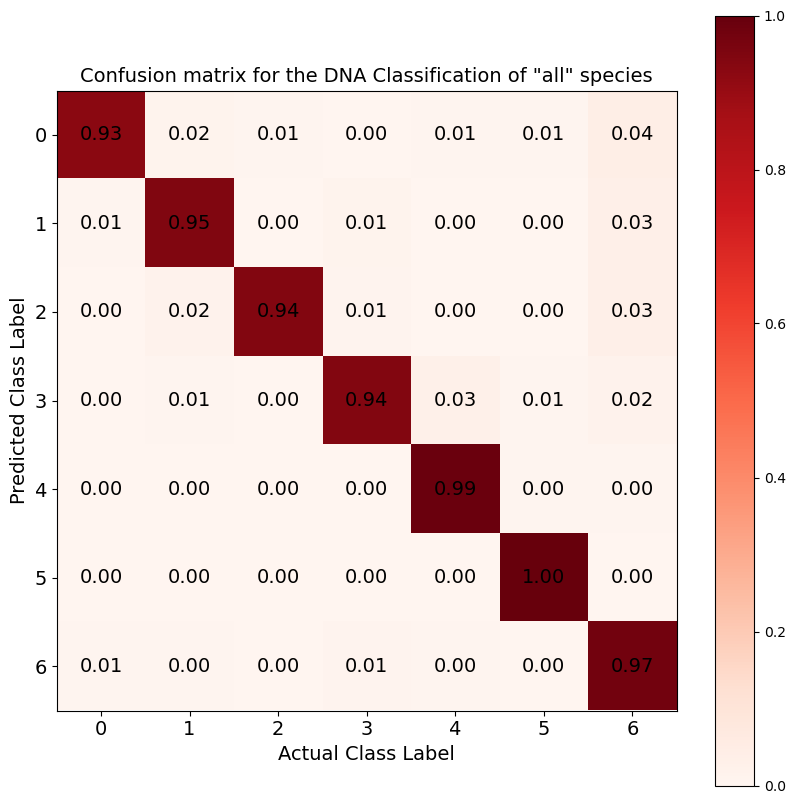

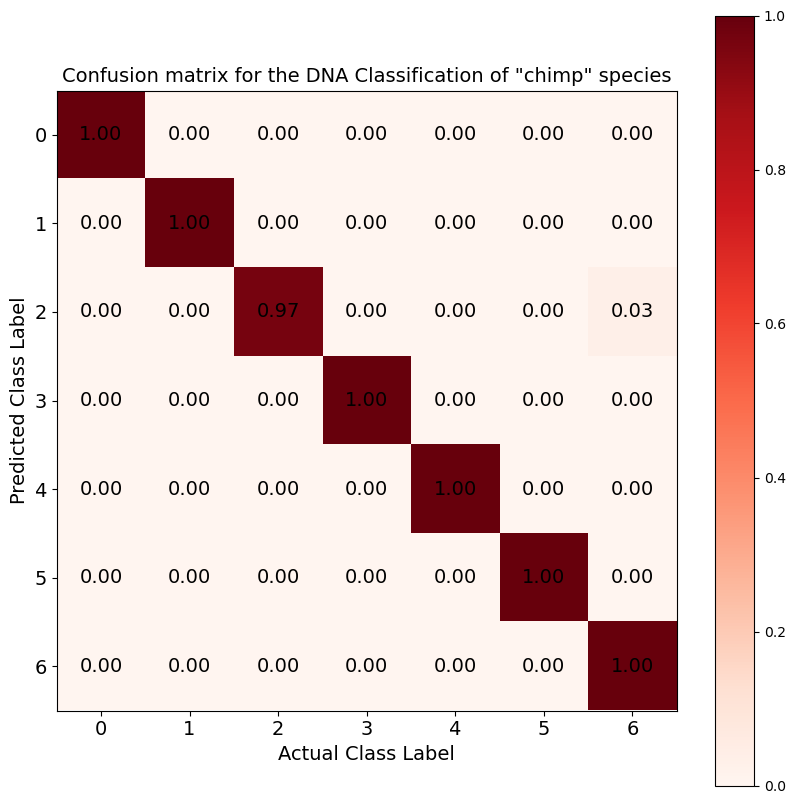

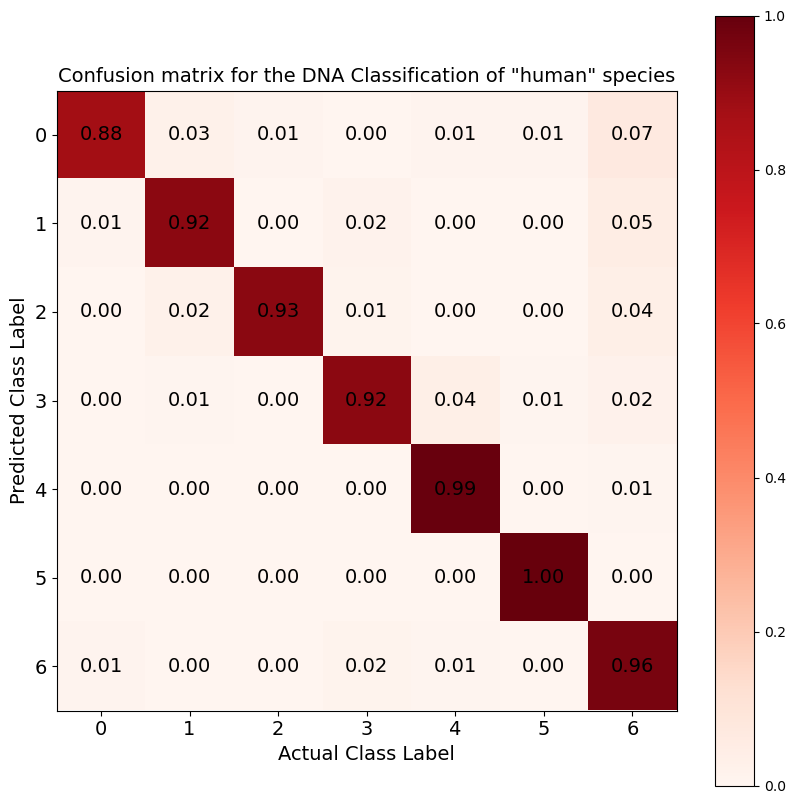

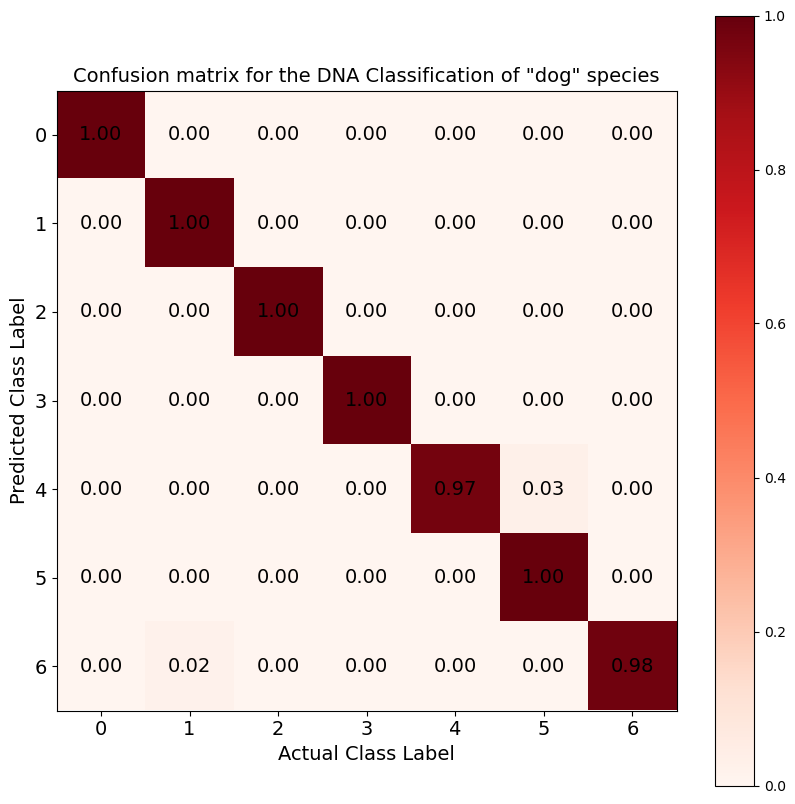

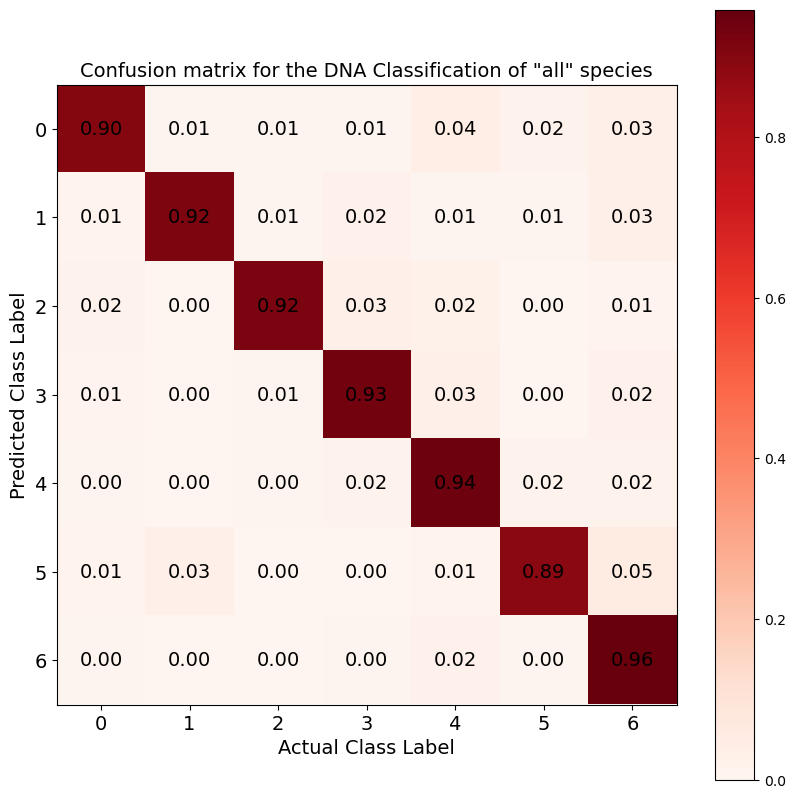

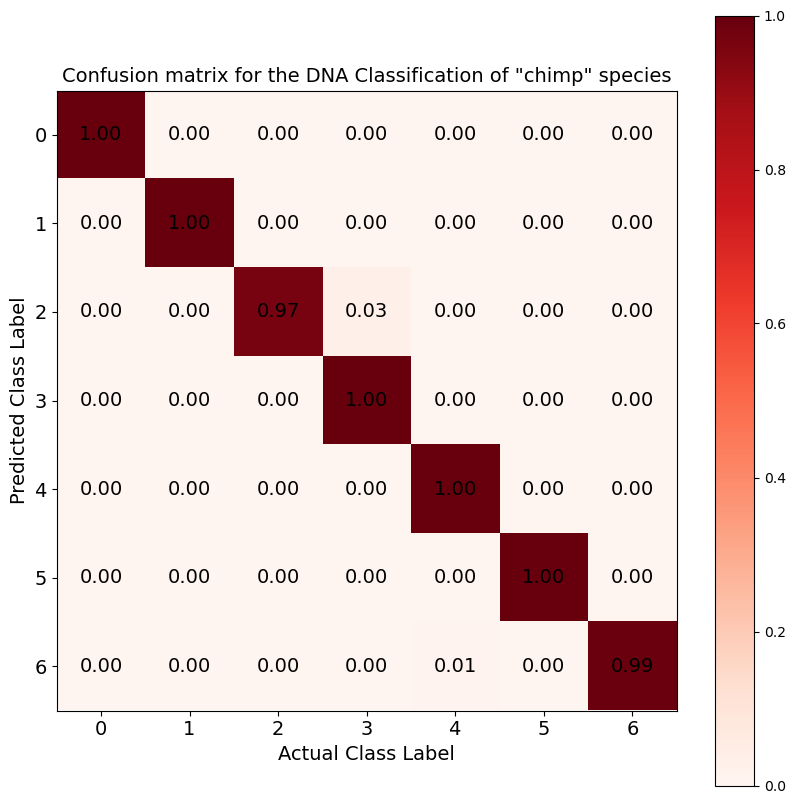

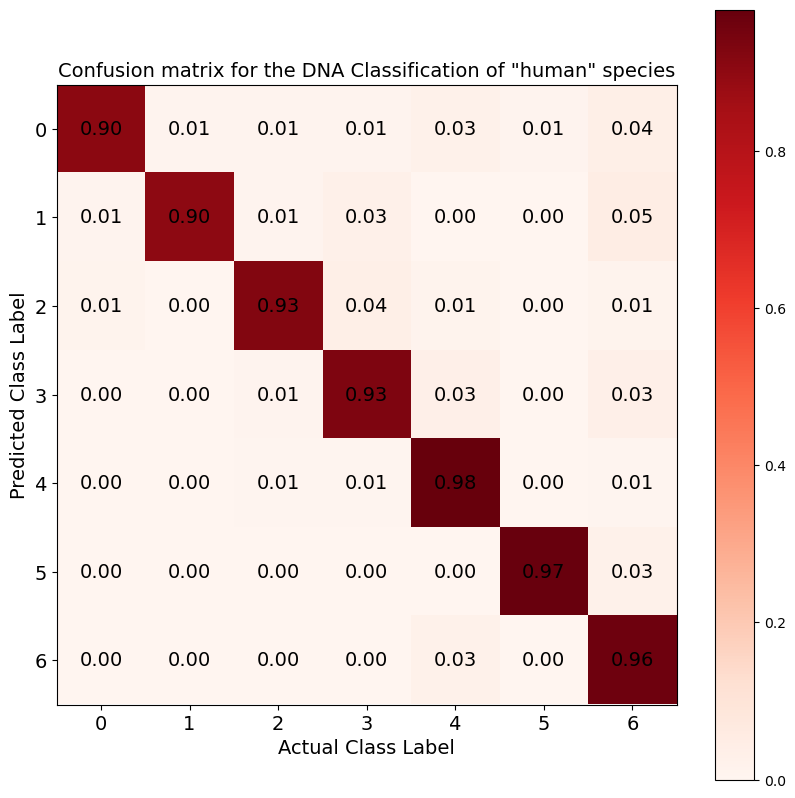

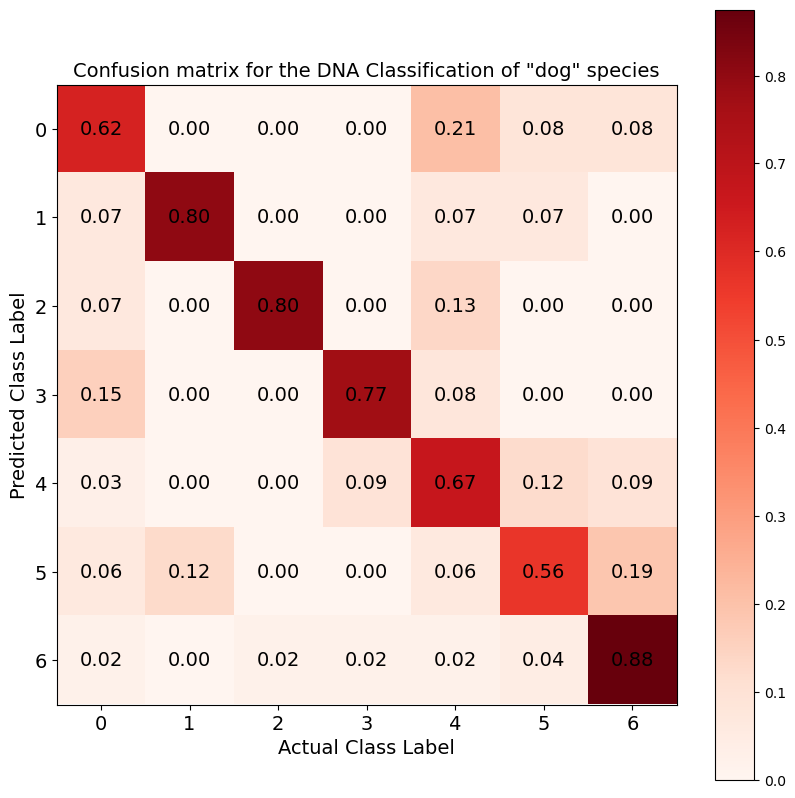

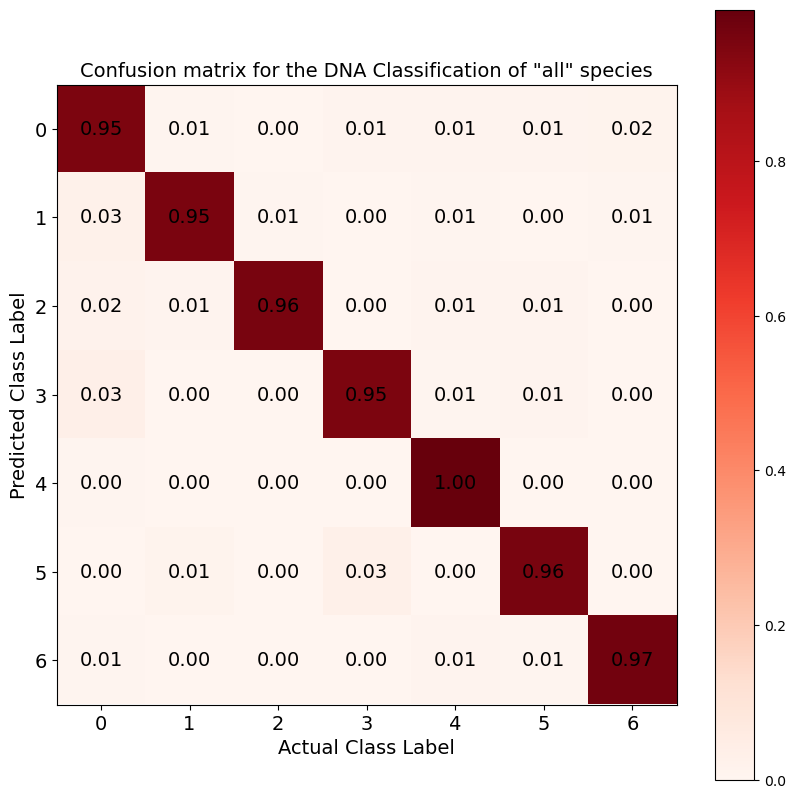

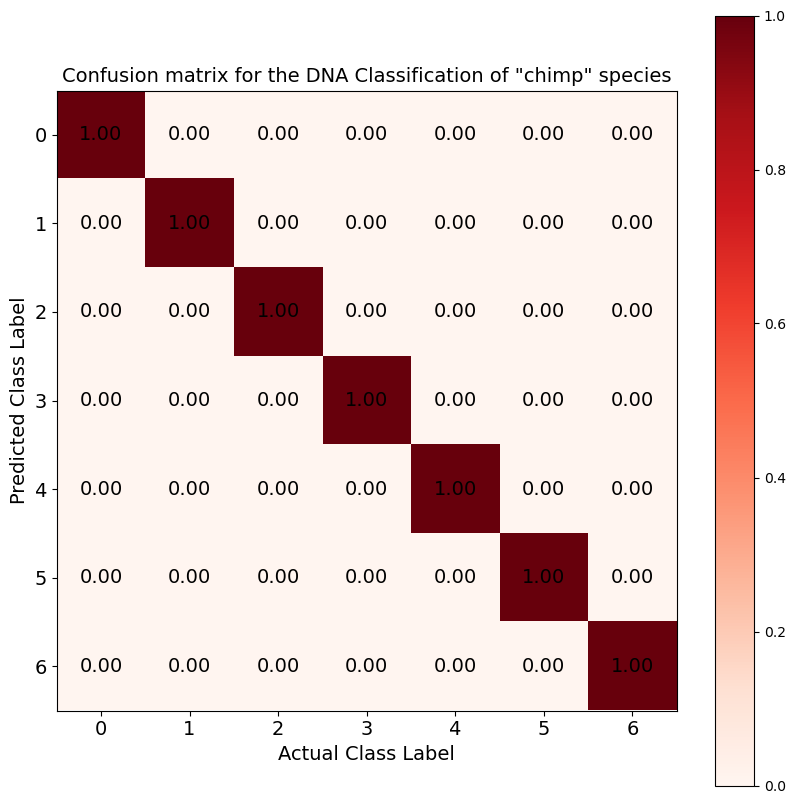

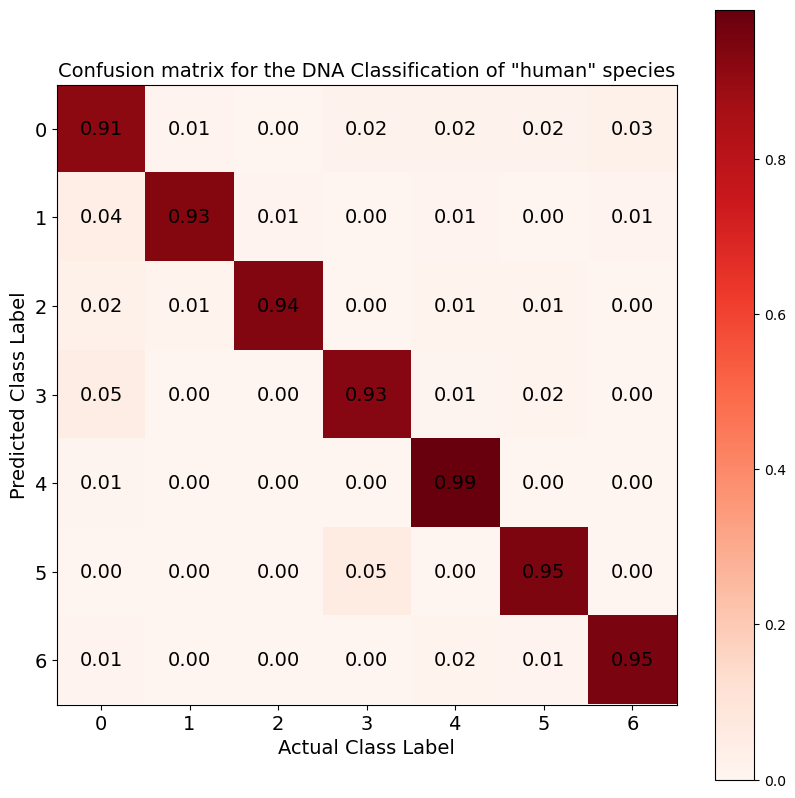

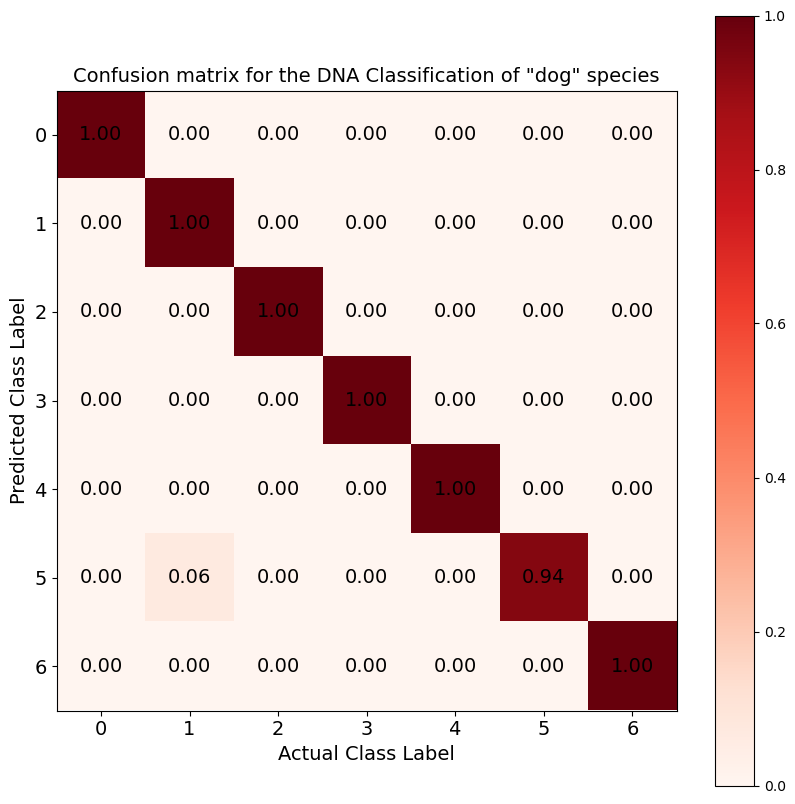

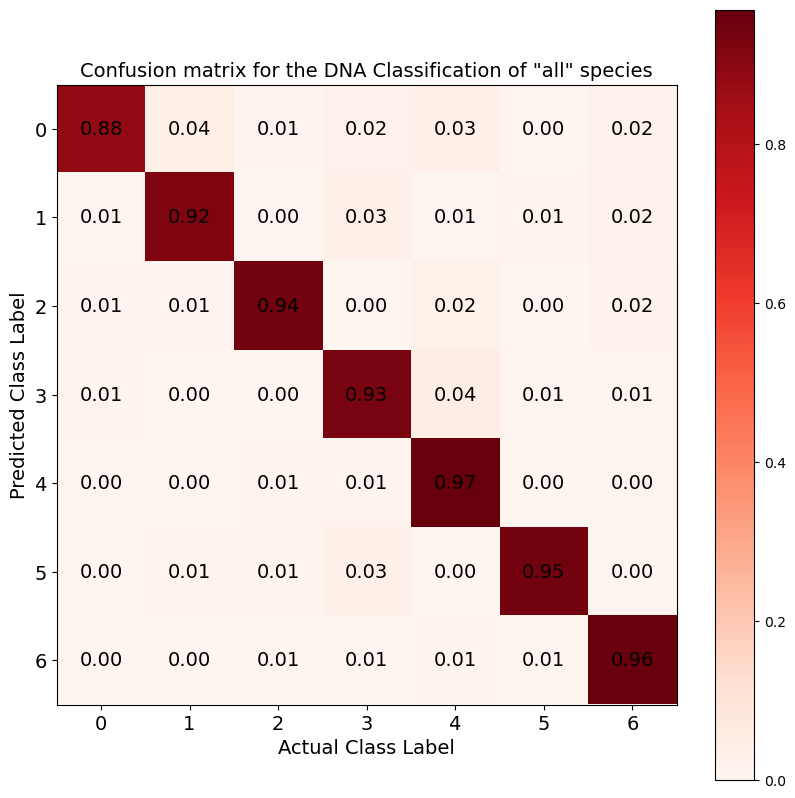

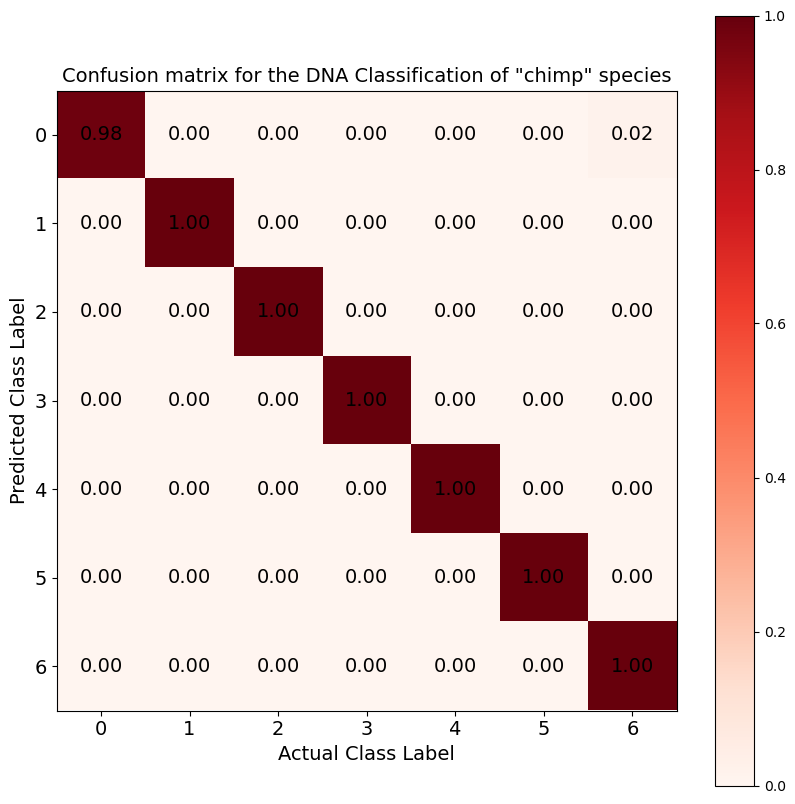

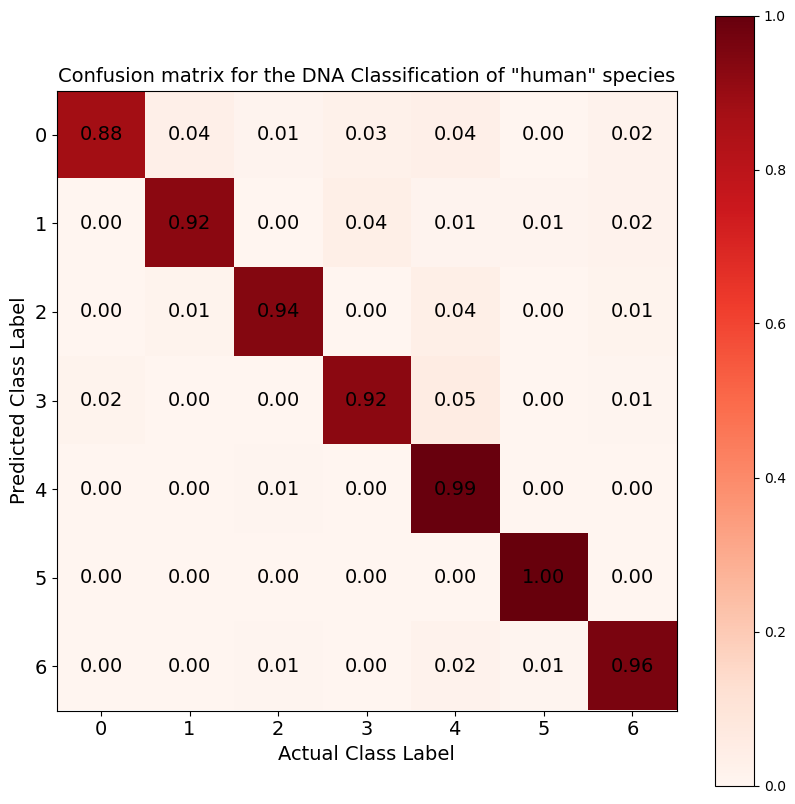

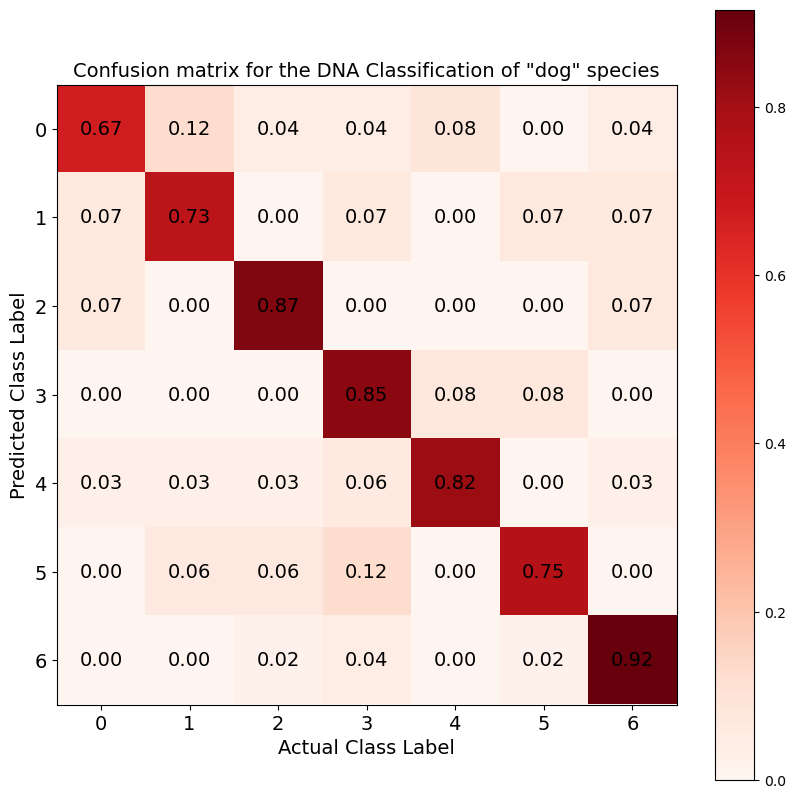

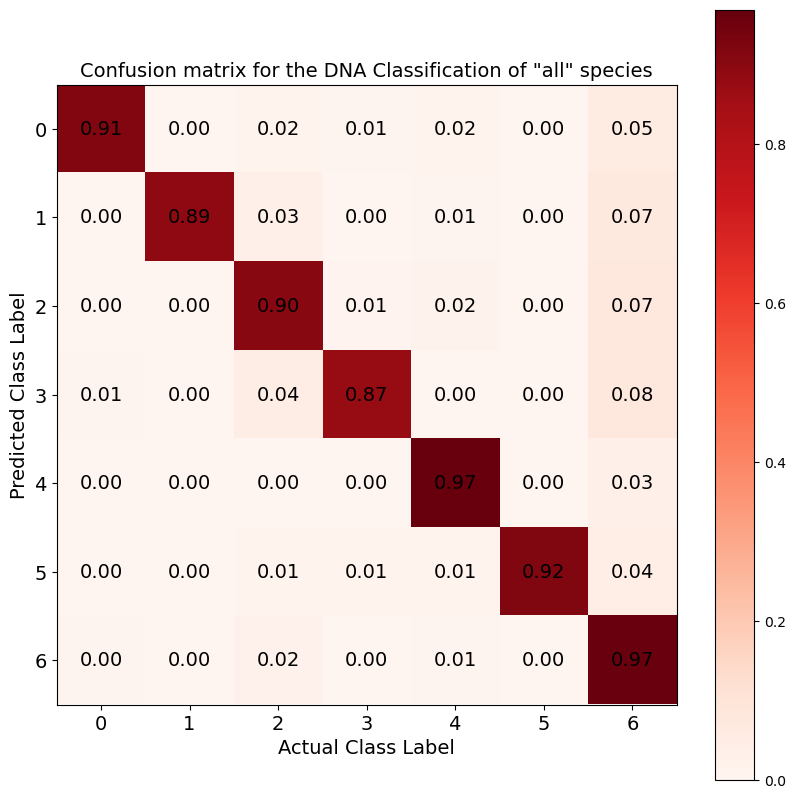

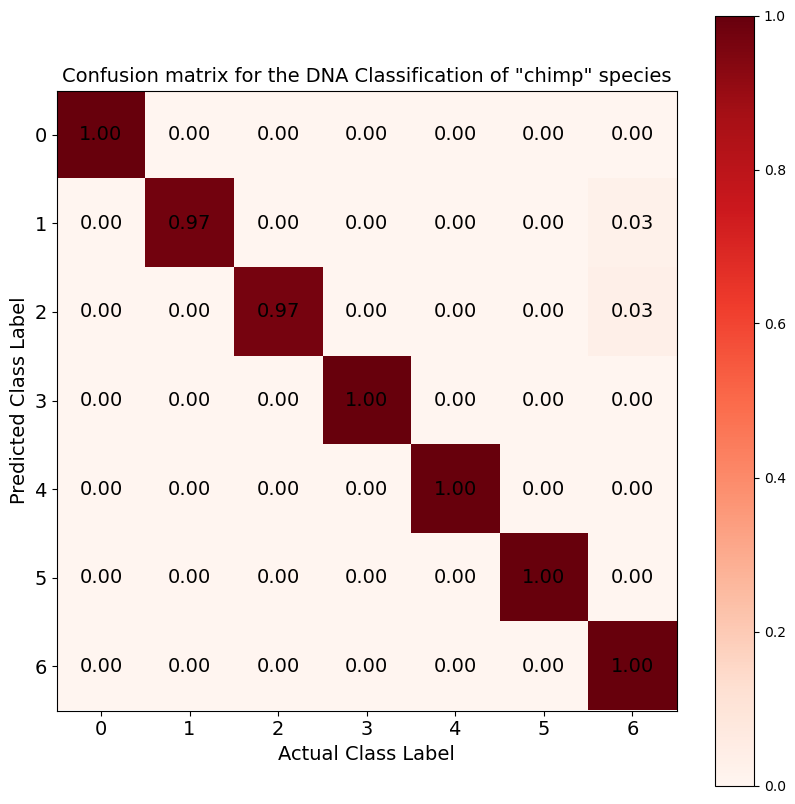

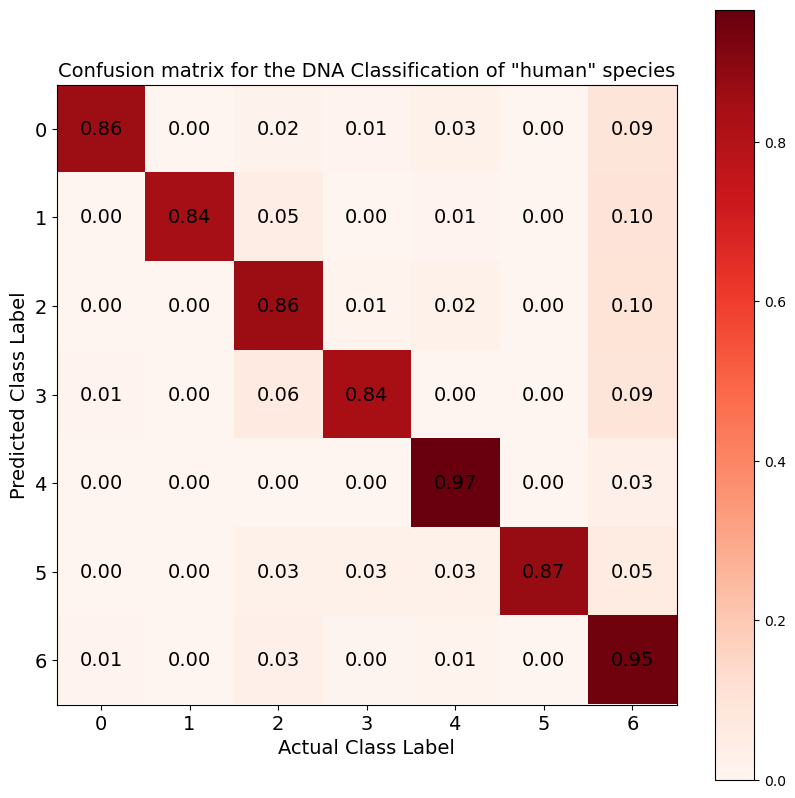

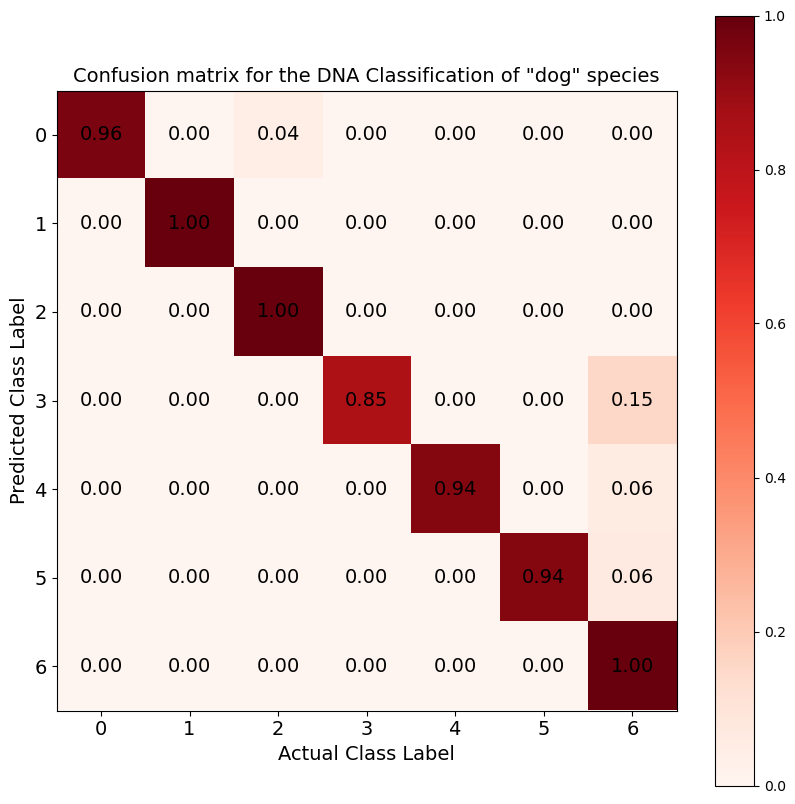

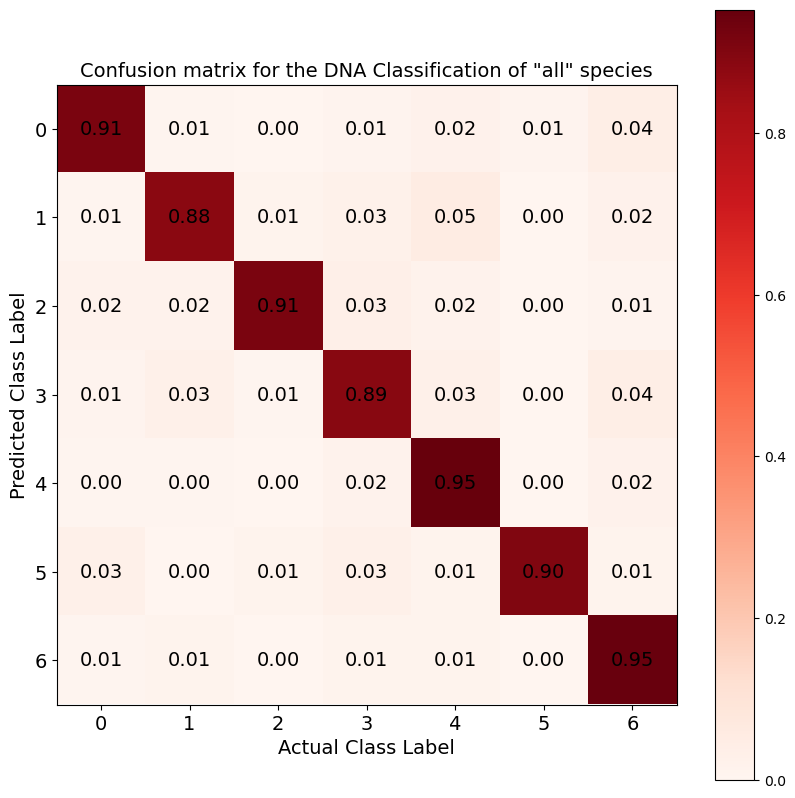

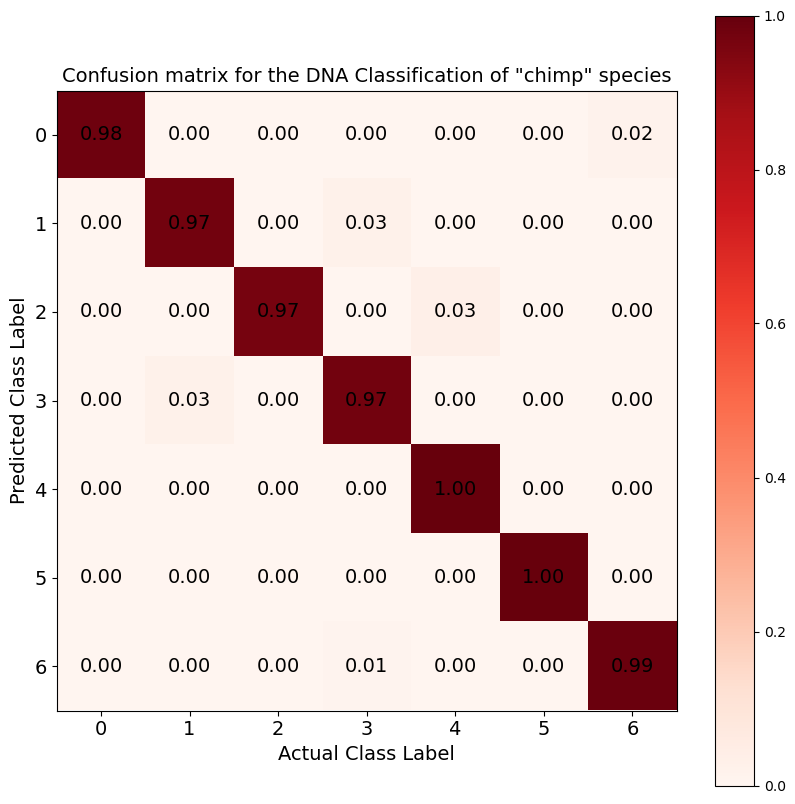

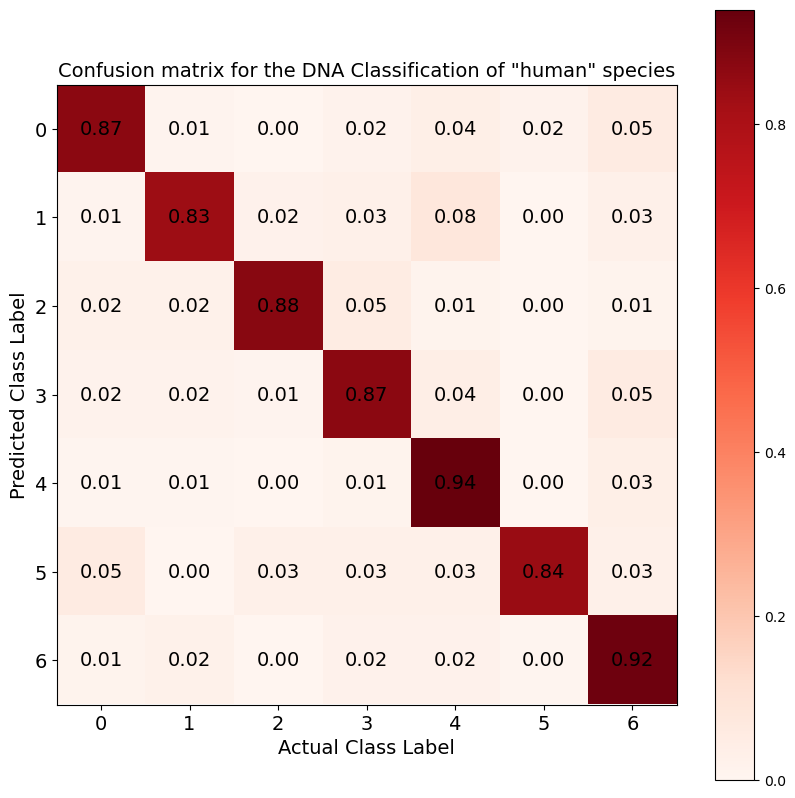

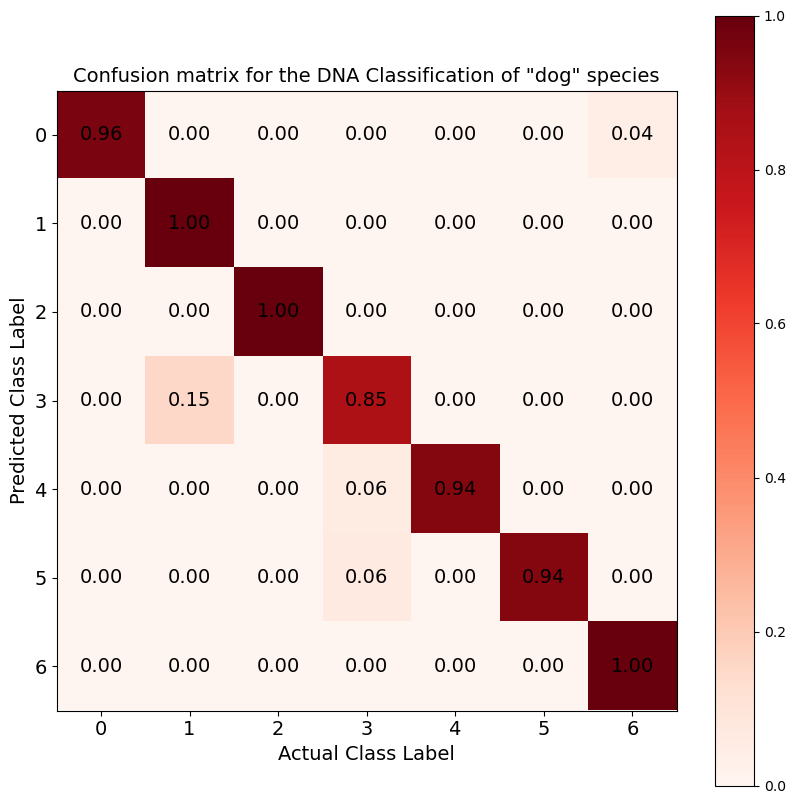

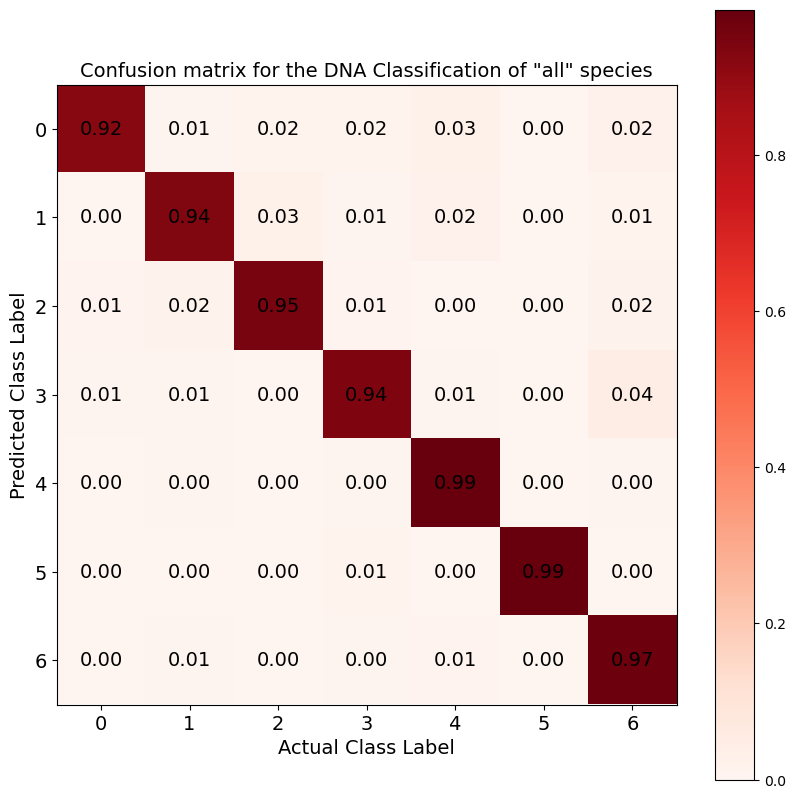

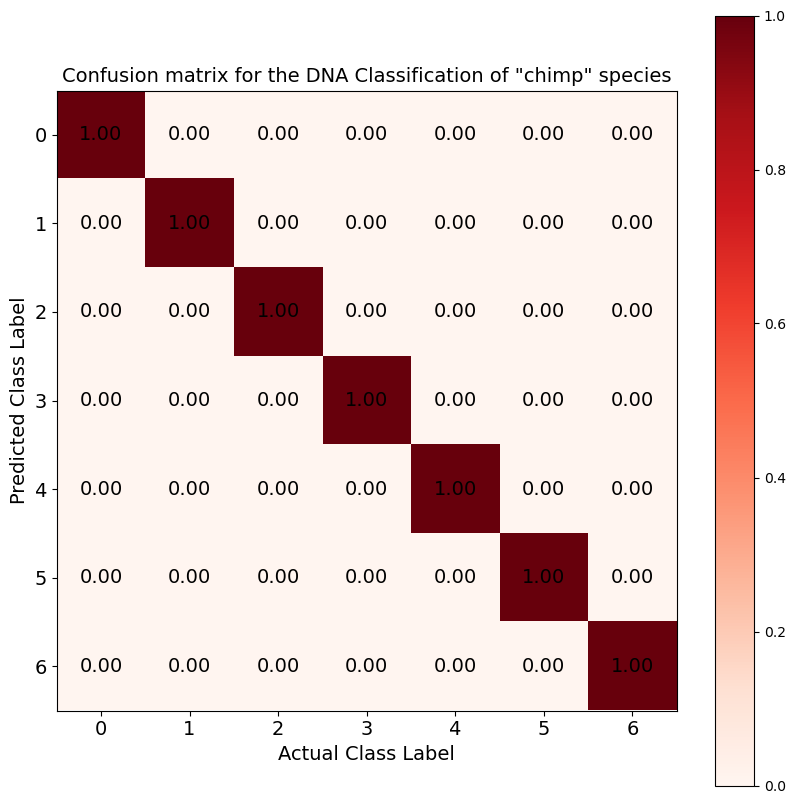

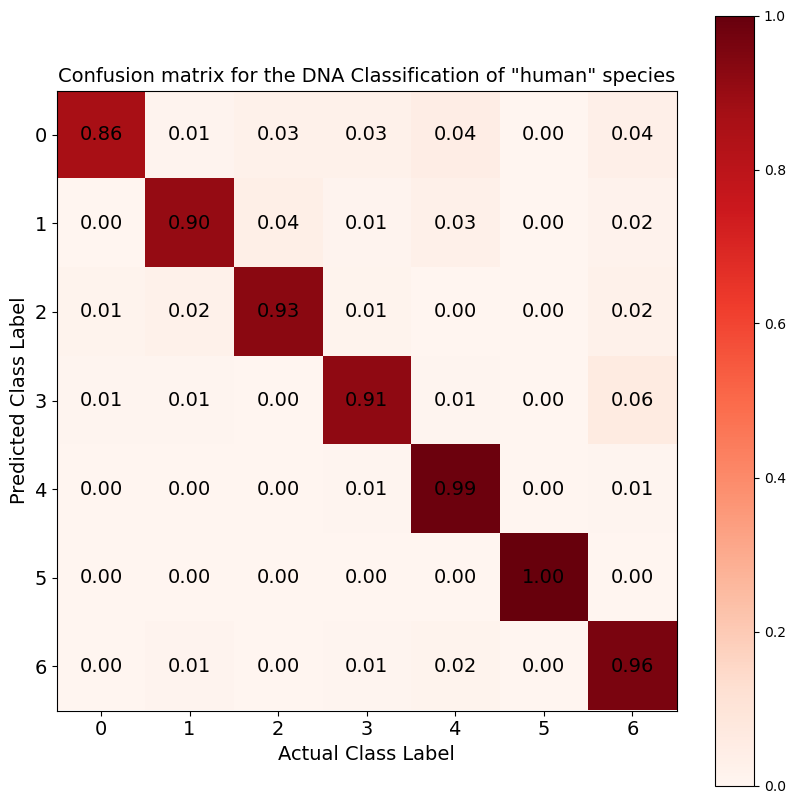

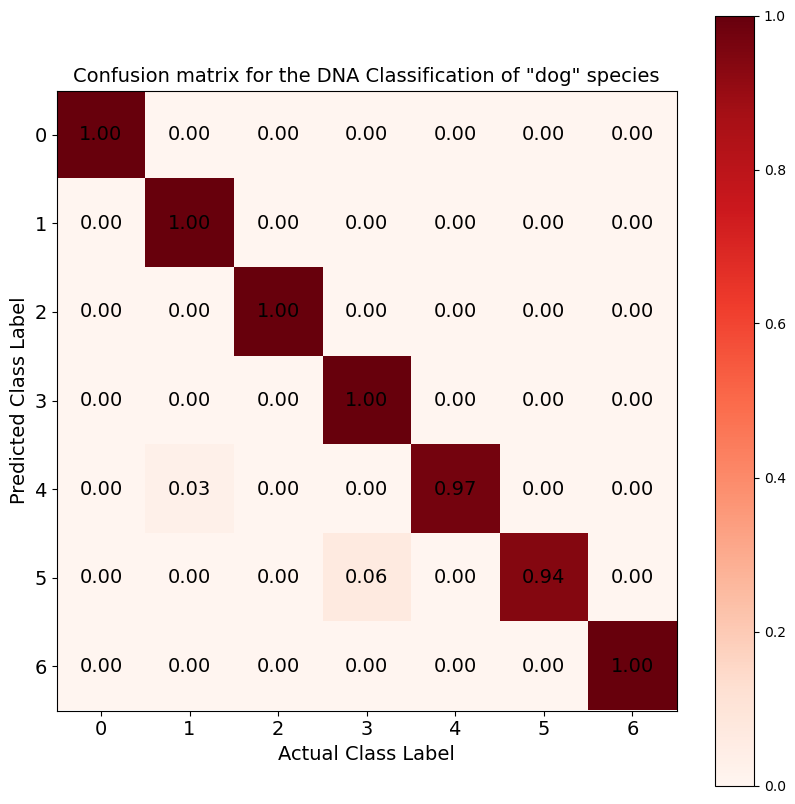

In [23]:
# loop through all the compression algorithms
compressions = ['gzip', 'snappy', 'brotli', 'lz4', 'zstandard', 'bz2', 'lzma']
#compressions =['brotli']

for compression in compressions:
    print('Compression algorithm: {}'.format(compression))
    # load the results
    distance_matrix = load_results(compression)
    # overall accuracy
    labels = test_df['class'].tolist()
    predictions = [label for label in train_df['class'][np.argmin(distance_matrix, axis=1)]]
    print("Confusion matrix for predictions on '{}' test sequences\n".format('all species'))
    print(pd.crosstab(pd.Series(labels, name='Actual'), pd.Series(predictions, name='Predicted')))
    accuracy, precision, recall, f1 = get_metrics(labels, predictions)
    print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))
    print('')
    # plot the confusion matrix for all the species
    plot_confusion_matrix(compression, 'all', labels, predictions)
    # write the same output to a file
    with open('overall_accuracy.txt', 'a') as f:
        f.write('Compression algorithm: {}\n'.format(compression))
        f.write("Confusion matrix for predictions on '{}' test sequences\n".format('all species'))
        f.write("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))
        f.write('\n')
    
    for species in ['chimp', 'human', 'dog']:
        # return the indices of the rows with species as chimp
        indices = test_df[test_df['species'] == species].index.values
        predictions = []
        for i in indices:
            # return the indices of the first 5 minimum values in the row
            index = np.argmin(distance_matrix[i, :])

            label = train_df['class'][index]
            # get the common label
            predictions.append(label)

        # get the actual labels
        labels = test_df[test_df['species'] == species]['class'].tolist()

        # performance on chimpanzee genes
        print("Confusion matrix for predictions on '{}' test sequences\n".format(species))
        print(pd.crosstab(pd.Series(labels, name='Actual'), pd.Series(predictions, name='Predicted')))
        accuracy, precision, recall, f1 = get_metrics(labels, predictions)
        print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))
        print('\n')
        # write the same output to a file
        with open('species_accuracy.txt', 'a') as f:
            f.write('Compression algorithm: {}\n'.format(compression))
            f.write("Confusion matrix for predictions on '{}' test sequences\n".format(species))
            f.write("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))
            f.write('\n')
        # plot the confusion matrix for all the species
        plot_confusion_matrix(compression, species, labels, predictions)

Text(0.5, 1.0, 'Class distribution of Human DNA')

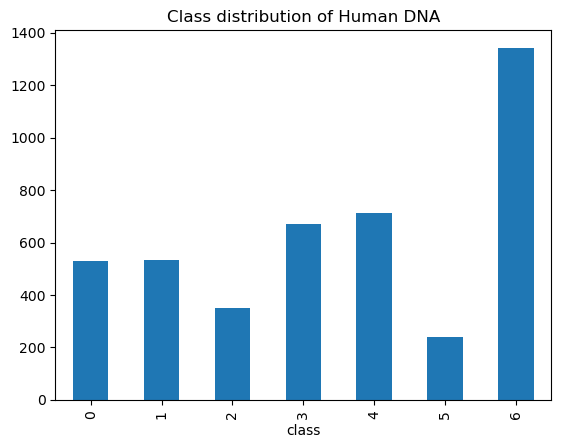

In [4]:
human_dna['class'].value_counts().sort_index().plot.bar()
plt.title("Class distribution of Human DNA")

Text(0.5, 1.0, 'Class distribution of Chimpanzee DNA')

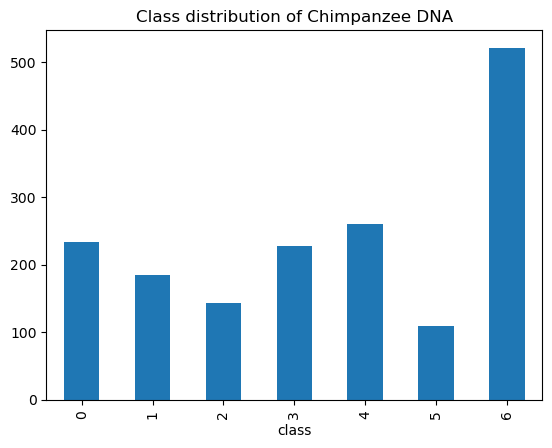

In [7]:
chimp_dna['class'].value_counts().sort_index().plot.bar()
plt.title("Class distribution of Chimpanzee DNA")

Text(0.5, 1.0, 'Class distribution of Dog DNA')

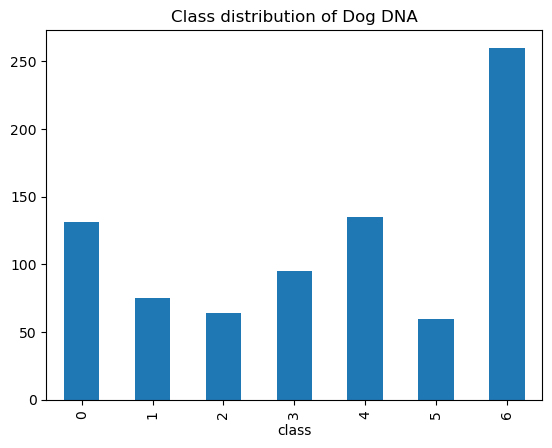

In [9]:
dog_dna['class'].value_counts().sort_index().plot.bar()
plt.title("Class distribution of Dog DNA")

Text(0.5, 1.0, 'Class distribution of all the DNA')

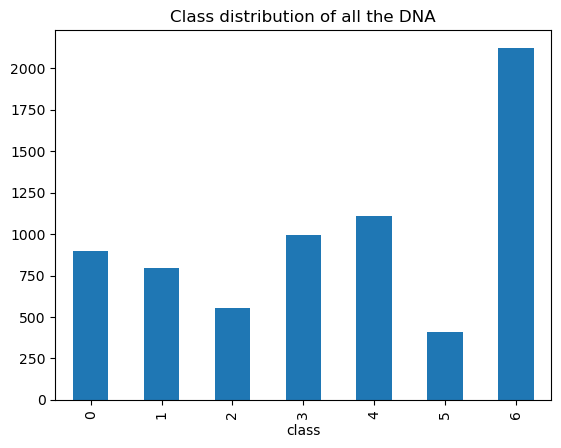

In [5]:
# concatenate all the dataframes into one
df = pd.concat([chimp_dna, human_dna, dog_dna])
df['class'].value_counts().sort_index().plot.bar()
plt.title("Class distribution of all the DNA")

In [10]:
print("Human DNA shape: ", human_dna.shape)
print("Chimpanzee DNA shape: ", chimp_dna.shape)
print("Dog DNA shape: ", dog_dna.shape)

Human DNA shape:  (4380, 2)
Chimpanzee DNA shape:  (1682, 2)
Dog DNA shape:  (820, 2)
